In [1]:
# import segmentation_models as sm
import os
import keras
import cv2
import numpy as np
import matplotlib.pyplot as plt
import albumentations as A
import tensorflow as tf
from skimage import io, color, exposure
from skimage.transform import rescale
from skimage.filters import unsharp_mask, sato
from skimage.filters import frangi
from skimage import io, filters, exposure
from PIL import Image

In [2]:
# train_image = "./train-images/01_dr.JPG"

In [3]:
import glob

original_images = []

path = './train-images/'

for i in range(1, 11):
    filename_pattern = f"{path}{i:02d}_h.JPG"
    
    file_list = glob.glob(filename_pattern)
    original_images.append(file_list[0])

In [4]:
def load_image(path):
    image = io.imread(path)    
    return image

In [5]:
def process_image(train_image):
    original_image = load_image(train_image)
    kernel = np.ones((5, 5), np.uint8)

    image_green_channel = original_image[:, :, 1]
    thresh = cv2.dilate(image_green_channel, kernel, iterations=1)
    denoised_image = cv2.fastNlMeansDenoising(thresh, None, 10, 5, 21)
    sharp_image = exposure.equalize_hist(denoised_image)
    frangi_image = frangi(sharp_image, scale_step=2) 

    frangi_image[frangi_image > 0.0001] = 255
    frangi_image[frangi_image <= 0.0001] = 0

    threshold_value = 100
    ret, thresh = cv2.threshold(frangi_image, threshold_value, 255, cv2.THRESH_BINARY)
    blackAndWhiteImage = cv2.erode(thresh, kernel)
    return frangi_image * blackAndWhiteImage

In [6]:
trained_images = []

for train_image in original_images:
    trained_images.append(process_image(train_image))

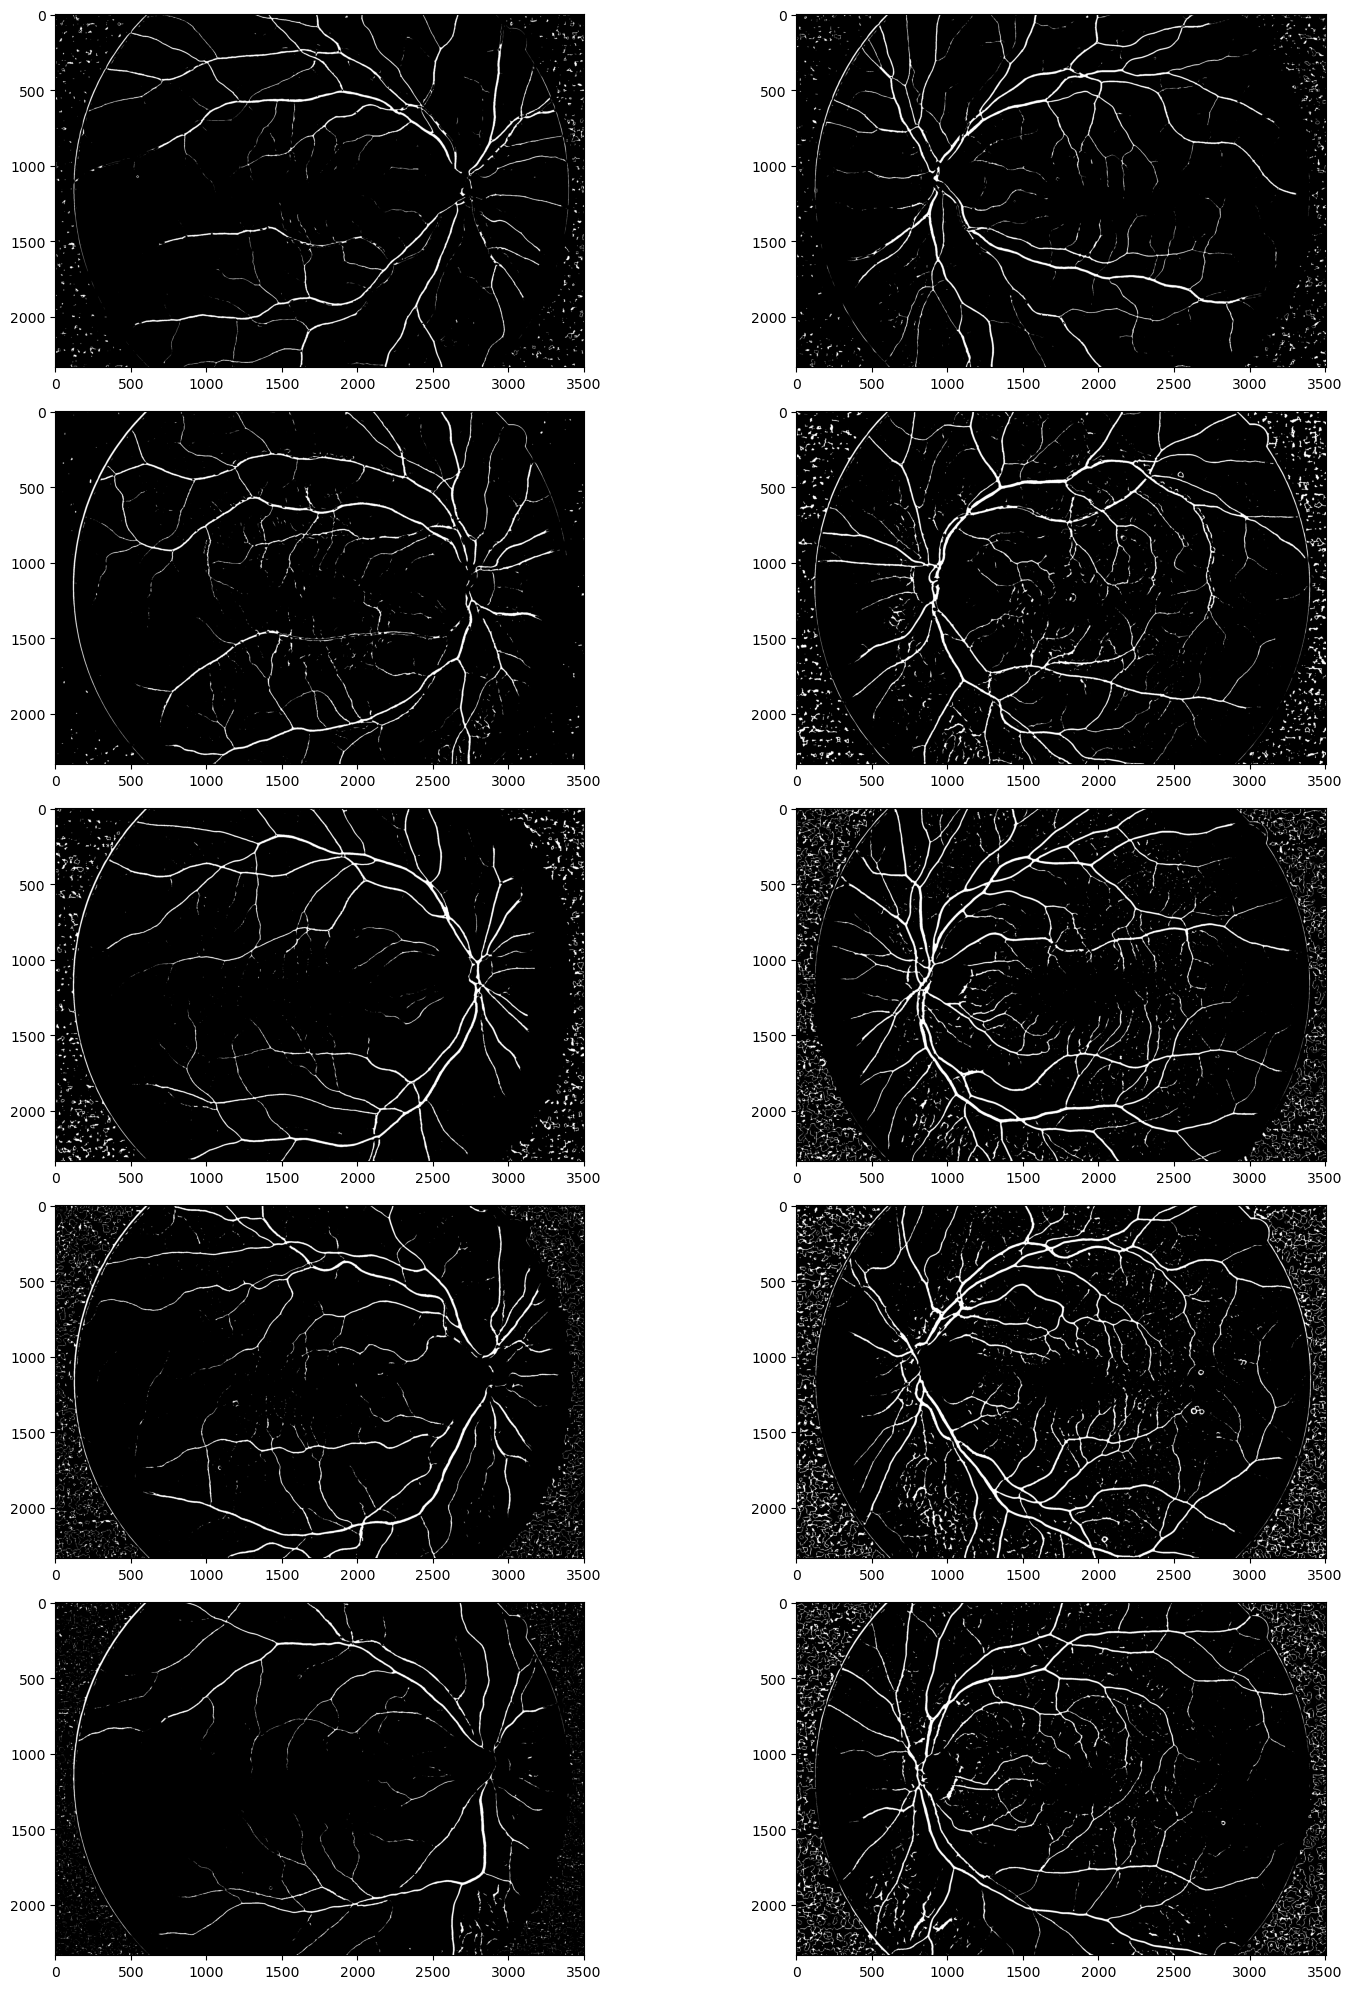

In [7]:
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(16, 20))

for idx, train_image in enumerate(original_images):
    row_idx = idx // 2
    col_idx = idx % 2
    axes[row_idx, col_idx].imshow(trained_images[idx], cmap='gray')
    
plt.tight_layout()
plt.show()

In [9]:
def remove_background(mask, image):
    detected_vessels_image = []

    for i, j in enumerate(image):
        vessels = []
        for x in j:
            if mask[i][x] < 100:
                vessels.append(0)
            else:
                vessels.append(image[i][x])

        detected_vessels_image.append(vessels)

    return detected_vessels_image

In [17]:
images_removed_background = []

path = './fov-mask/'

for i in range(1, 11):
    filename_pattern = f"{path}{i:02d}_h_mask.tif"
    mask = cv2.imread(filename_pattern, cv2.IMREAD_GRAYSCALE)
    images_removed_background.append(remove_background(mask, trained_images[i - 1]))

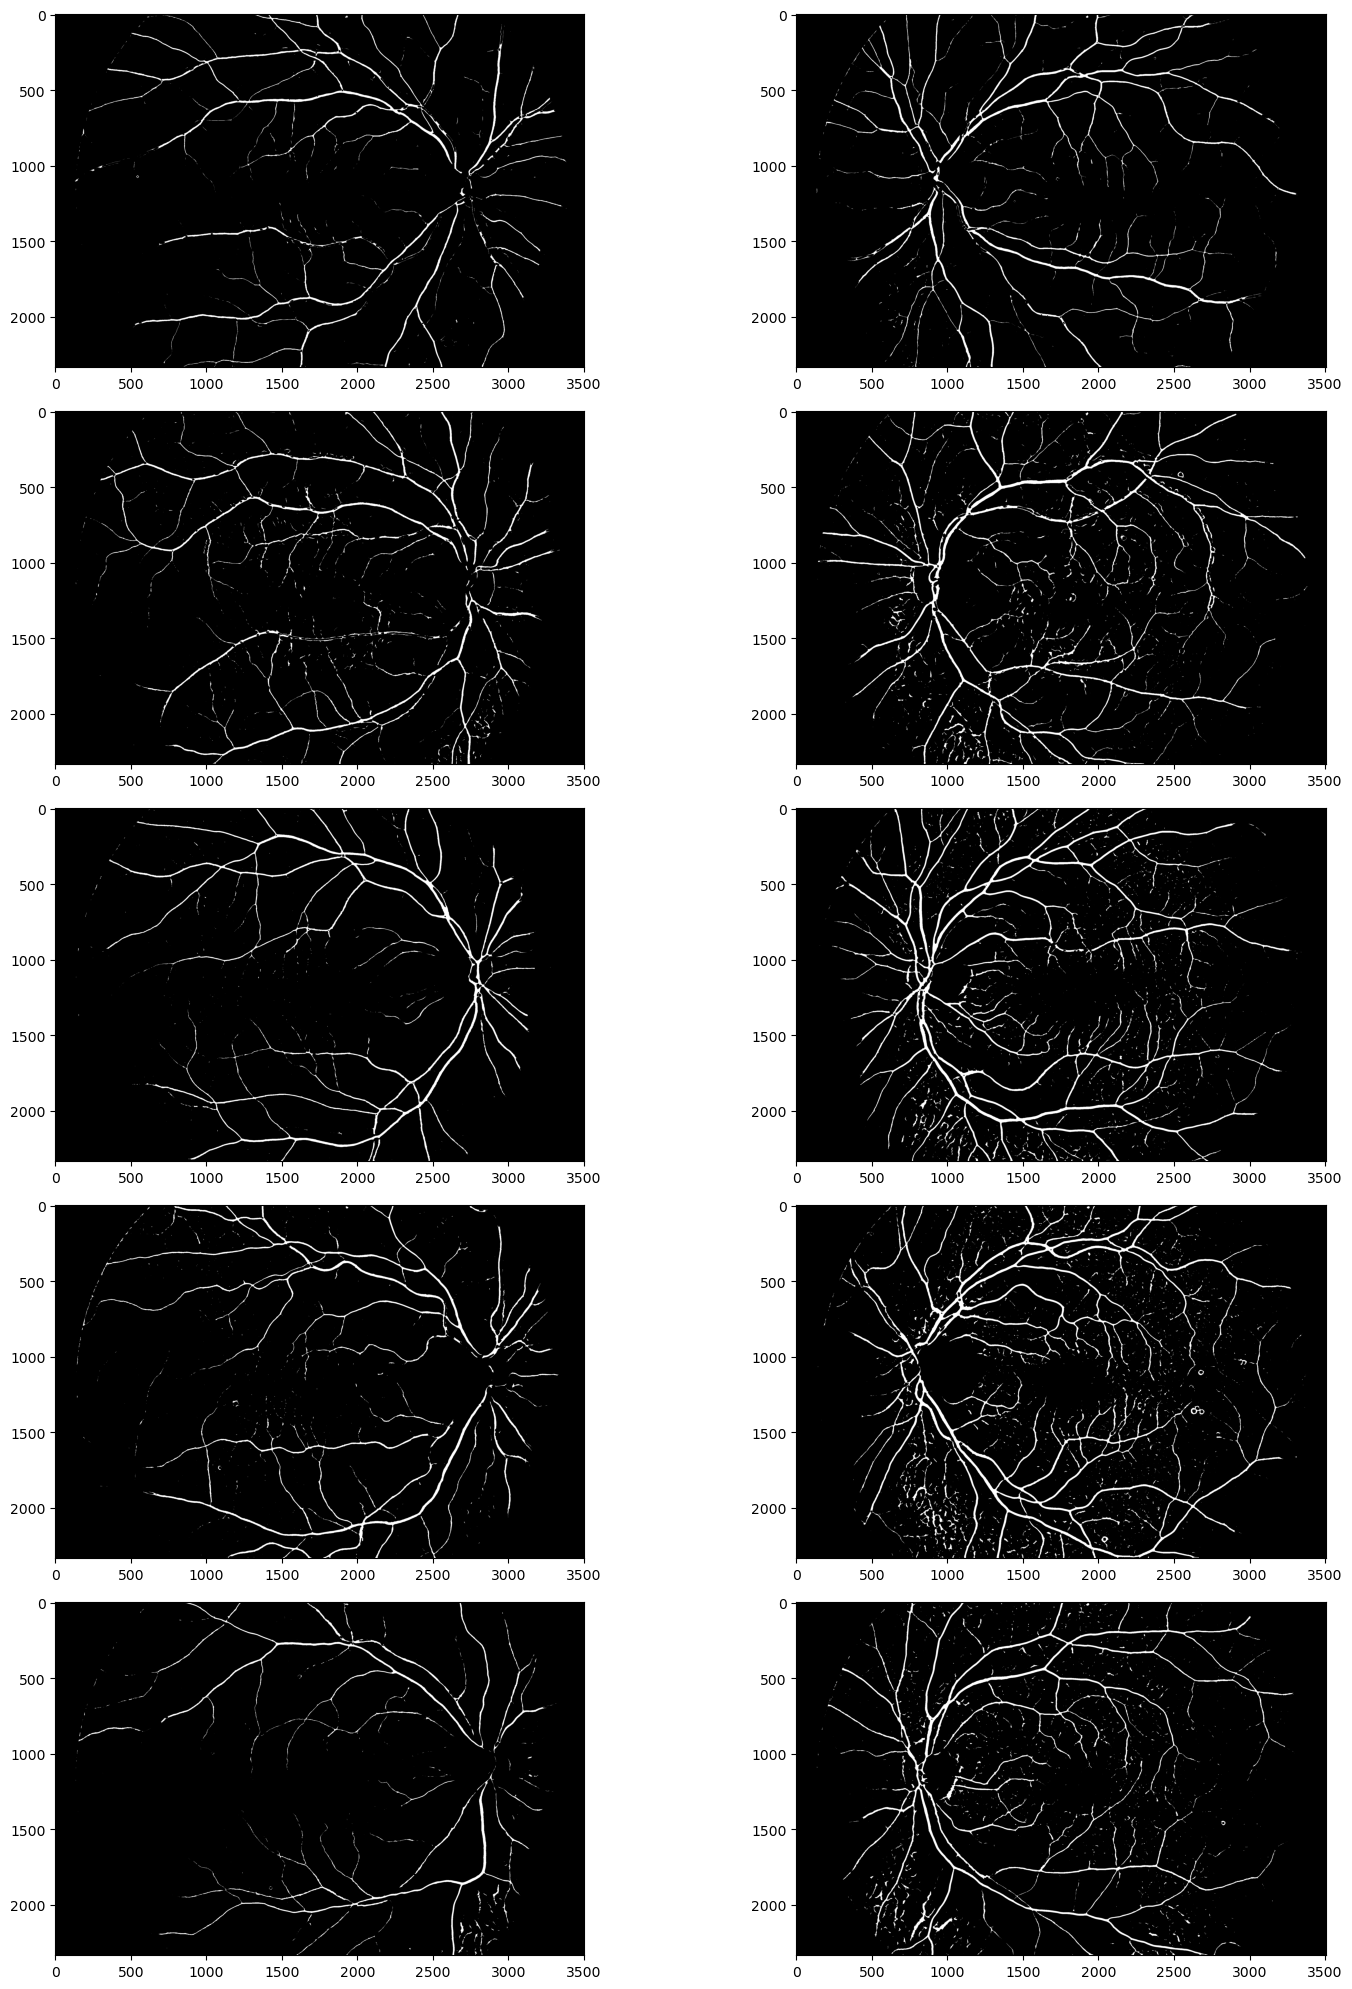

In [18]:
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(16, 20))

for idx, image in enumerate(images_removed_background):
    row_idx = idx // 2
    col_idx = idx % 2
    axes[row_idx, col_idx].imshow(image, cmap='gray')
    
plt.tight_layout()
plt.show()

In [21]:
manually_labeled_images = []
path = './manually_labeled_images/'

for i in range(1, 11):
    filename_pattern = f"{path}{i:02d}_h.tif"
    manually_labeled_image = cv2.imread(filename_pattern, cv2.IMREAD_GRAYSCALE)
    manually_labeled_images.append(manually_labeled_image)
    

In [ ]:
from sklearn.metrics import confusion_matrix

def get_confusion_matrix_values(image):
    confusion_mat = confusion_matrix(image.flatten(), np.array(detected_vessels_image).flatten())
    true_negative, false_positive, false_negative, true_positive = confusion_mat.ravel()
    accuracy = (true_positive + true_negative) / (true_positive + false_positive + false_negative + true_negative)
    sensitivity = true_positive / (true_positive + false_negative)
    specificity = true_negative / (true_negative + false_positive)

    print(confusion_mat)


In [ ]:
print(np.array(detected_vessels_image, dtype=np.float32))
detected_vessels_image = np.array(detected_vessels_image, dtype=np.float32)

In [22]:
def get_segments(image):
    parts_num = 5
    num_rows = image.shape[0] // parts_num
    num_cols = image.shape[1] // parts_num
    segments = []

    for i in range(0, num_rows, parts_num):
        for j in range(0, num_cols, parts_num):
            mat_5x5 = image[i: i + parts_num, j: j + parts_num]
            segments.append(mat_5x5)
    
    return segments


In [87]:
images_segments = []

for image in images_removed_background:
    images_segments.append(get_segments(np.array(image)))

In [94]:
from skimage.measure import regionprops
def get_image_statistics(segments):
    segment_stats = np.array([])

    for segment in segments:

        variance = np.var(segment)
        moments = cv2.moments(segment)
        central_moments = cv2.centralMoments(moments)
        hu_moments = cv2.HuMoments(central_moments)
    
        # prop = regionprops(segment, dtype=np.float32)
        # segment = np.expand_dims(segment, axis=-1)
        # std_dev = np.std(segment)
        # mean_intensity = prop.mean_intensity
        # std_intensity = prop.std_intensity
        # segment_stats = np.concatenate((mean_intensity, std_intensity))
    return segment_stats


In [95]:
images_statistics = []

for i, image in enumerate(images_segments):
    images_statistics.append(get_image_statistics(image))

AttributeError: module 'cv2' has no attribute 'centralMoments'

In [97]:
!pip uninstall opencv-python
!pip uninstall opencv-contrib-python
!pip uninstall opencv-contrib-python-headless
!pip3 install opencv-contrib-python==4.5.5.62

In [ ]:
# from sklearn.ensemble import RandomForestClassifier

# rf = RandomForestClassifier()
# rf.fit(manually_labeled_image_stats, detected_vessels_image_stats)

In [ ]:
X, y = train[features], train[labels]

sampler = RandomUnderSampler(sampling_strategy=1, random_state=seed)
X, y = sampler.fit_resample(X, y)